# Proof of concept for using crosstalk to manipulate output of circuit
- noise/error_rates example taken from ibm_challenge 2024 lab4

## imports

In [1]:
# Import all in one cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

from qiskit.visualization import plot_histogram

## define fake backend and fake_noisy backend

In [2]:
#define coupling map
coupling_map = [[0,1],[1,0],[1,2],[2,1],[0,2],[2,0],[2,3],[3,2],[2,4],[4,2],[3,4],[4,3]]

In [3]:
fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"],
    coupling_map = coupling_map
  )

In [4]:
print(fake_backend.coupling_map)

[[0, 1], [1, 0], [1, 2], [2, 1], [0, 2], [2, 0], [2, 3], [3, 2], [2, 4], [4, 2], [3, 4], [4, 3]]


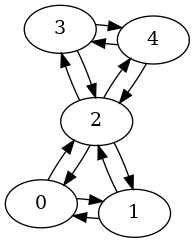

In [5]:
fake_backend.coupling_map.draw()

In [6]:
fake_noisy_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"],
    coupling_map = coupling_map
  )

In [7]:
print(fake_noisy_backend.target)

Target: Generic Target with 5 qubits
Number of qubits: 5
Instructions:
	id
		(0,):
			Duration: 4.3512e-08 sec.
			Error Rate: 9.597199551150542e-05
		(1,):
			Duration: 3.6852000000000005e-08 sec.
			Error Rate: 9.479928308319267e-05
		(2,):
			Duration: 5.0394e-08 sec.
			Error Rate: 9.066285815810387e-05
		(3,):
			Duration: 4.3068e-08 sec.
			Error Rate: 9.22867222078475e-05
		(4,):
			Duration: 3.441e-08 sec.
			Error Rate: 9.692669632056093e-05
	rz
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(2,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(3,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(4,):
			Duration: 0.0 sec.
			Error Rate: 0.0
	sx
		(0,):
			Duration: 4.6398e-08 sec.
			Error Rate: 9.69264108343935e-05
		(1,):
			Duration: 5.9052000000000005e-08 sec.
			Error Rate: 9.450770949271228e-05
		(2,):
			Duration: 4.1514000000000004e-08 sec.
			Error Rate: 9.217731246287728e-05
		(3,):
			Duration: 4.7952000000000005e-08 sec

In [8]:
def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

In [9]:
error_rates = {
  #"default_duration": 1e-8,
  #"rz_error": 1e-8,
  "x_error": 1e-4,
  #"sx_error": 1e-8,
  #"measure_error": 1e-8,
  "cx_error": 2e-2
}

update_error_rate(fake_noisy_backend, error_rates)

In [10]:
print(fake_noisy_backend.target)

Target: Generic Target with 5 qubits
Number of qubits: 5
Instructions:
	id
		(0,):
			Duration: 4.3512e-08 sec.
			Error Rate: 9.597199551150542e-05
		(1,):
			Duration: 3.6852000000000005e-08 sec.
			Error Rate: 9.479928308319267e-05
		(2,):
			Duration: 5.0394e-08 sec.
			Error Rate: 9.066285815810387e-05
		(3,):
			Duration: 4.3068e-08 sec.
			Error Rate: 9.22867222078475e-05
		(4,):
			Duration: 3.441e-08 sec.
			Error Rate: 9.692669632056093e-05
	rz
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(2,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(3,):
			Duration: 0.0 sec.
			Error Rate: 0.0
		(4,):
			Duration: 0.0 sec.
			Error Rate: 0.0
	sx
		(0,):
			Duration: 4.6398e-08 sec.
			Error Rate: 9.69264108343935e-05
		(1,):
			Duration: 5.9052000000000005e-08 sec.
			Error Rate: 9.450770949271228e-05
		(2,):
			Duration: 4.1514000000000004e-08 sec.
			Error Rate: 9.217731246287728e-05
		(3,):
			Duration: 4.7952000000000005e-08 sec

## define our dummy circuit

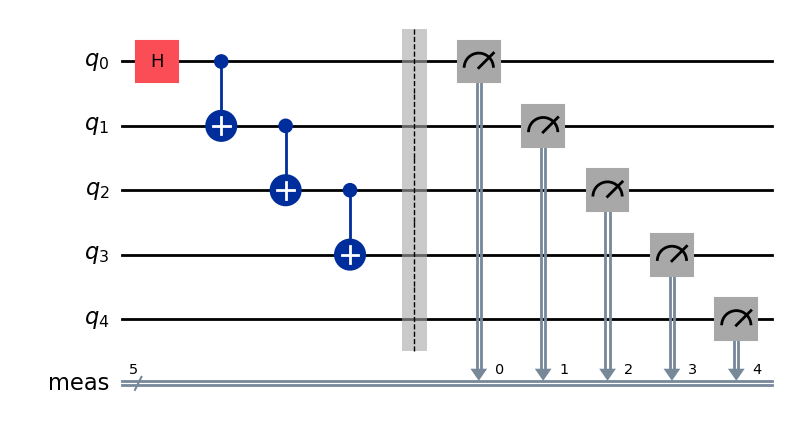

In [11]:
# Make a quantum circuit -> GHZ state
qc = QuantumCircuit(5)#Add your code
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.measure_all()

qc.draw("mpl")

## use fake backend

In [12]:
sampler = Sampler(fake_backend)
pm = generate_preset_pass_manager(optimization_level=0, backend=fake_backend, seed_transpiler=0)

In [13]:
qc_isa = pm.run(qc)

In [14]:
pub = (qc_isa)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'01111': 472, '00000': 515, '01110': 3, '00011': 1, '01011': 4, '00001': 1, '01101': 1, '00111': 3}


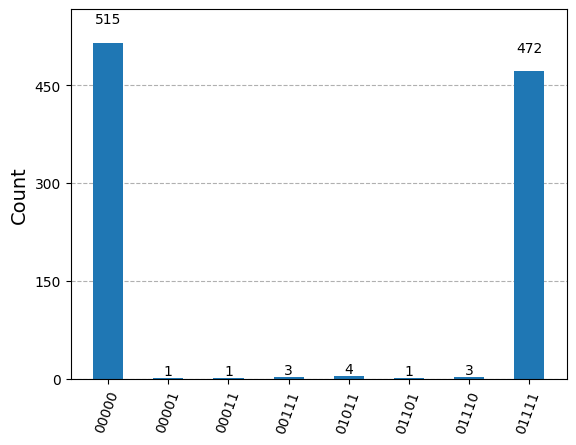

In [15]:
plot_histogram(counts_sampler)

## use fake noisy backend

In [16]:
sampler = Sampler(fake_noisy_backend)
pm = generate_preset_pass_manager(optimization_level=0, backend=fake_noisy_backend, seed_transpiler=0)

In [17]:
qc_isa_noise = pm.run(qc)

In [18]:
pub = (qc_isa_noise)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'01111': 484, '00000': 448, '00100': 5, '01110': 7, '00001': 17, '01000': 1, '00010': 7, '01100': 5, '01011': 6, '00011': 6, '01001': 1, '01010': 1, '01101': 7, '00111': 5}


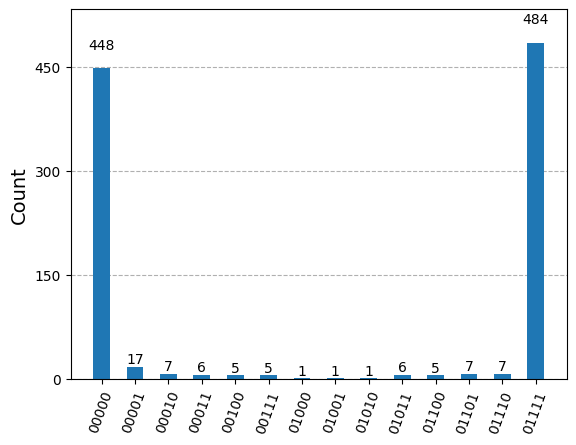

In [19]:
plot_histogram(counts_sampler)

## manipulate circuit 1q-gate

In [20]:
qc_manipulate = QuantumCircuit(5,5)

In [21]:
for i in range(0,10000):
    qc_manipulate.h(1)

In [22]:
qc_manipulate = qc_manipulate.compose(qc)
qc_manipulate.measure_all()

In [23]:
#qc_manipulate.draw("mpl")

In [24]:
qc_isa_tempered = pm.run(qc_manipulate)

In [25]:
#qc_isa_tempered.draw("mpl")

In [26]:
pub = (qc_isa_tempered)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'01111': 375, '00000': 355, '01110': 123, '00001': 104, '01101': 6, '01010': 2, '01011': 4, '01000': 4, '00111': 2, '00010': 7, '01100': 5, '01001': 2, '00011': 9, '00101': 1, '00100': 1}


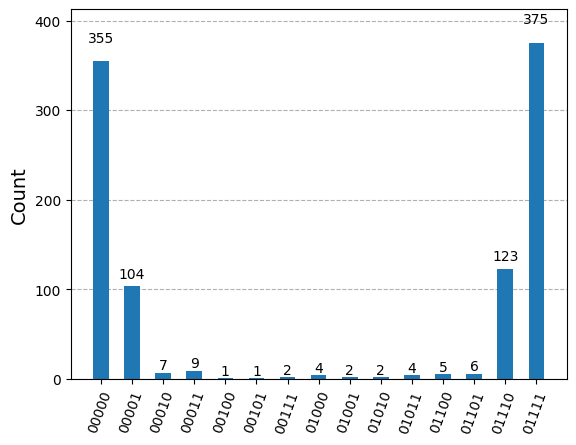

In [27]:
plot_histogram(counts_sampler)

## manipulate circuit 2q-gate

In [28]:
qc_manipulate2 = QuantumCircuit(5,5)

In [29]:
for i in range(0,1000):
    qc_manipulate2.cx(0,1)

In [30]:
qc_manipulate2 = qc_manipulate2.compose(qc)
qc_manipulate2.measure_all()

In [31]:
qc_isa_tempered2 = pm.run(qc_manipulate2)

In [32]:
pub = (qc_isa_tempered2)
job_sampler = sampler.run([pub], shots=1000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'00000': 237, '00001': 255, '01111': 251, '01110': 212, '00110': 4, '01101': 10, '01100': 5, '01010': 2, '00111': 2, '00100': 1, '01001': 3, '00011': 7, '00010': 6, '11111': 1, '01000': 1, '01011': 3}


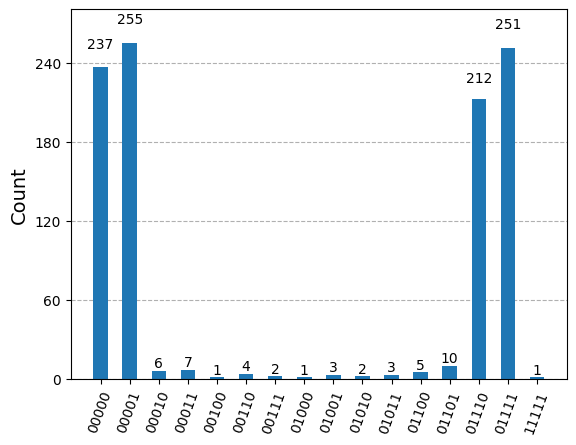

In [33]:
plot_histogram(counts_sampler)